# 1. Log on target sem Final Raw Material cost (€/Part)

## 1.1 Recherche

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-17 18:24:37,688] A new study created in memory with name: no-name-1933b188-7277-4812-bbe0-841bbae9c8cb


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-17 18:26:56,018] Trial 0 finished with value: 0.07246310069089638 and parameters: {'iterations': 562, 'depth': 6, 'learning_rate': 0.08960785365368121, 'l2_leaf_reg': 6.387926357773329, 'subsample': 0.7468055921327309, 'min_data_in_leaf': 12, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.07246310069089638.
[I 2025-05-17 18:30:26,628] Trial 1 finished with value: 0.091246266614343 and parameters: {'iterations': 721, 'depth': 5, 'learning_rate': 0.010636066512540286, 'l2_leaf_reg': 9.72918866945795, 'subsample': 0.9497327922401265, 'min_data_in_leaf': 14, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.07246310069089638.
[I 2025-05-17 18:32:55,604] Trial 2 finished with value: 0.06980993890077339 and parameters: {'iterations': 513, 'depth': 5, 'learning_rate': 0.03647316284911211, 'l2_leaf_reg': 3.6210622617823773, 'subsample': 0.8835558684167139, 'min_data_in_leaf': 11, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.06980993890077339.
[I 20

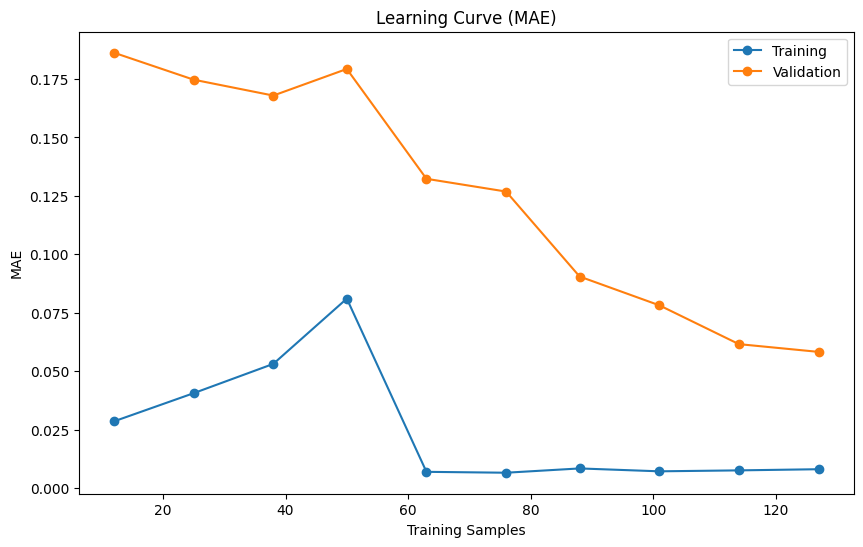

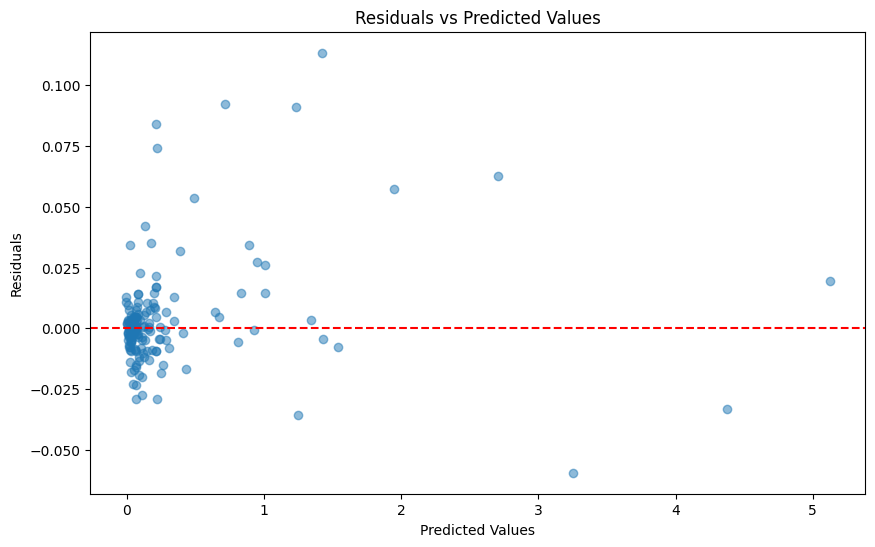

Best Parameters:
{'iterations': 966, 'depth': 6, 'learning_rate': 0.0380289049090876, 'l2_leaf_reg': 1.7939989663568956, 'subsample': 0.7034347454701829, 'min_data_in_leaf': 43, 'grow_policy': 'Depthwise'}
Best MAE: 0.0629

Final Model Evaluation:
R² Score: 0.9989
MAE: 0.0127
RMSE: 0.0223


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2]:
import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import learning_curve
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA PREPARATION (UNCHANGED)
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)'
])
df['Raw Material'] = df['Raw Material'].str.title()

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# BAYESIAN OPTIMIZATION SETUP
# --------------------------
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'depth': trial.suggest_int('depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'cat_features': list(range(len(num_cols), len(num_cols) + len(cat_cols))),
        'random_seed': 42,
        'verbose': False
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    maes = []
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test_original = y_original.iloc[test_idx]
        
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', CatBoostRegressor(**params))
        ])
        
        model.fit(X_train, y_train)
        
        # Predict and reverse log transform
        log_y_pred = model.predict(X_test)
        y_pred = np.expm1(log_y_pred)
        
        maes.append(mean_absolute_error(y_test_original, y_pred))
    
    return np.mean(maes)

# --------------------------
# OPTIMIZATION EXECUTION
# --------------------------
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42, multivariate=True)
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

# --------------------------
# FINAL MODEL & VISUALIZATION
# --------------------------
best_params = study.best_params
best_params['cat_features'] = list(range(len(num_cols), len(num_cols) + len(cat_cols)))
best_params['verbose'] = False

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(**best_params))
])
final_model.fit(X, y)

# Learning Curves
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(1), 'o-', label='Training')
plt.plot(train_sizes, -val_scores.mean(1), 'o-', label='Validation')
plt.title('Learning Curve (MAE)')
plt.xlabel('Training Samples')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Residual Plot
log_y_pred = final_model.predict(X)
y_pred = np.expm1(log_y_pred)
residuals = y_original - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

print("Best Parameters:")
print(study.best_params)
print(f"Best MAE: {study.best_value:.4f}")

# --------------------------
# FINAL METRICS EVALUATION
# --------------------------
mae = mean_absolute_error(y_original, y_pred)
rmse = mean_squared_error(y_original, y_pred, squared=False)
r2 = r2_score(y_original, y_pred)

print("\nFinal Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


## 1.2 Test

10-fold CV Results:
MAE: 0.0652 ± 0.0578
RMSE: 0.1270 ± 0.1243
R²: 0.9367 ± 0.0588

Percentage Error Evaluation:
Mean % Error: 47.81%
% of Predictions within 5%% Error: 16.35%


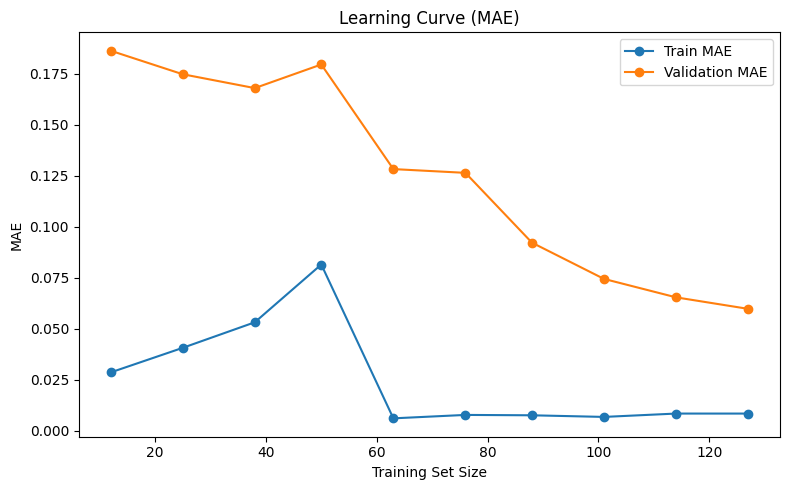

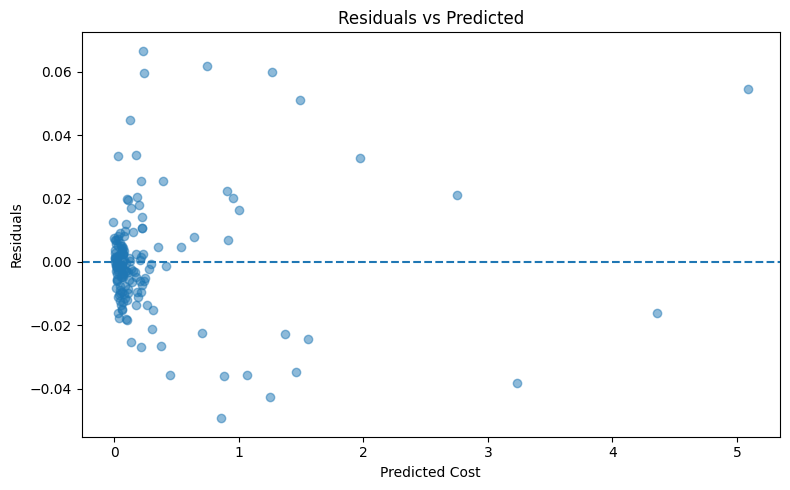

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA LOADING & PREP
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)'
])
df['Raw Material'] = df['Raw Material'].str.title()

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)',
    'Thickness (mm)', 'Part Net Weight (g)',
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material',
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# PREPROCESSOR & MODEL SETUP
# --------------------------
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)
], remainder='passthrough')

fixed_params = {
    'iterations': 966,
    'depth': 6,
    'learning_rate': 0.0380289049090876,
    'l2_leaf_reg': 1.7939989663568956,
    'subsample': 0.7034347454701829,
    'min_data_in_leaf': 43,
    'grow_policy': 'Depthwise',
    'cat_features': list(range(len(num_cols), len(num_cols) + len(cat_cols))),
    'random_seed': 42,
    'verbose': False
}

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**fixed_params))
])

# --------------------------
# SINGLE 10-FOLD EVALUATION
# --------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mae_scores, rmse_scores, r2_scores = [], [], []
percent_errors = []

eps = 1e-9

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y_original.iloc[test_idx]

    model.fit(X_train, y_train)
    log_pred = model.predict(X_test)
    y_pred = np.expm1(log_pred)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(root_mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

    percent_error = np.abs((y_test - y_pred) / (y_test + eps)) * 100
    percent_errors.extend(percent_error)

print("10-fold CV Results:")
print(f"MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

percent_errors = np.array(percent_errors)
within_5_percent = np.mean(percent_errors <= 5) * 100
mean_percent_error = np.mean(percent_errors)

print(f"\nPercentage Error Evaluation:")
print(f"Mean % Error: {mean_percent_error:.2f}%")
print(f"% of Predictions within 5%% Error: {within_5_percent:.2f}%")

# --------------------------
# LEARNING CURVE
# --------------------------
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y,
    cv=5,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, -train_scores.mean(axis=1), marker='o', label='Train MAE')
plt.plot(train_sizes, -val_scores.mean(axis=1), marker='o', label='Validation MAE')
plt.title('Learning Curve (MAE)')
plt.xlabel('Training Set Size')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# RESIDUAL PLOT
# --------------------------
# Fit on full data
model.fit(X, y)
log_full_pred = model.predict(X)
y_full_pred = np.expm1(log_full_pred)
residuals = y_original - y_full_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_full_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Cost')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

# 2. IQR + Log on target Final Raw Material cost (€/Part)

## Recherche

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-18 17:37:57,701] A new study created in memory with name: no-name-5723abb5-52fa-4bf2-8c63-3e957c471555


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-18 17:40:17,763] Trial 0 finished with value: 0.028356069187872545 and parameters: {'iterations': 812, 'depth': 6, 'learning_rate': 0.041959818254342154, 'l2_leaf_reg': 2.197316968394073, 'subsample': 0.6656018640442437, 'min_data_in_leaf': 34, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.028356069187872545.
[I 2025-05-18 17:42:20,124] Trial 1 finished with value: 0.03286606293668703 and parameters: {'iterations': 717, 'depth': 6, 'learning_rate': 0.038033450352296265, 'l2_leaf_reg': 2.416145155592091, 'subsample': 0.6520584494295802, 'min_data_in_leaf': 60, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.028356069187872545.
[I 2025-05-18 17:44:29,108] Trial 2 finished with value: 0.028905435696962484 and parameters: {'iterations': 950, 'depth': 4, 'learning_rate': 0.02545474901621302, 'l2_leaf_reg': 1.3668090197068676, 'subsample': 0.6804242242959538, 'min_data_in_leaf': 46, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.0283560691878725

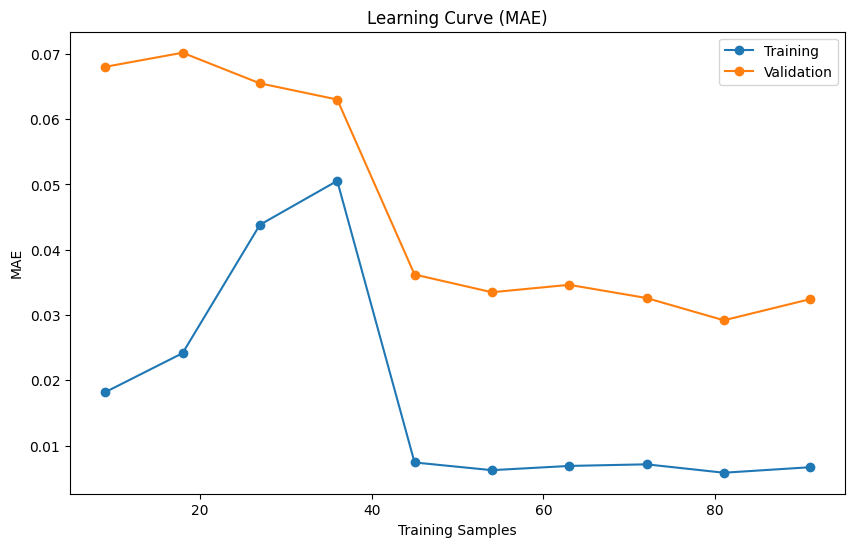

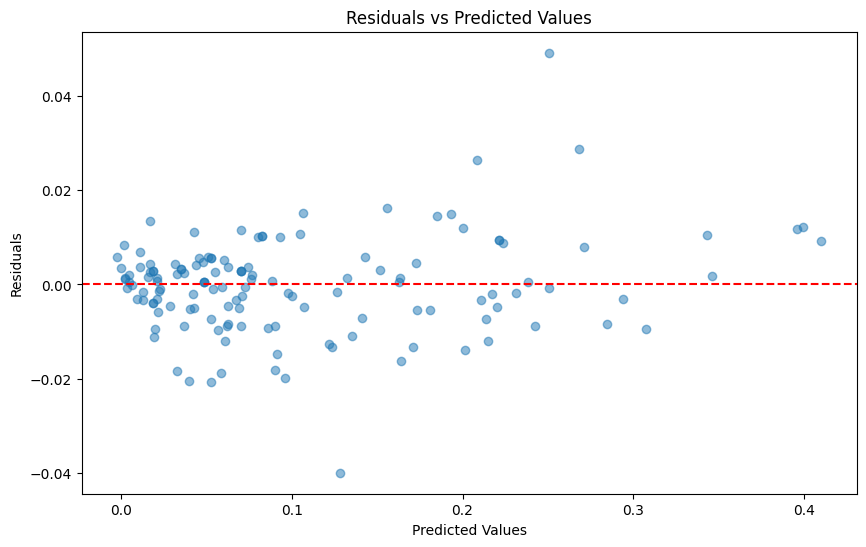

Best Parameters:
{'iterations': 948, 'depth': 6, 'learning_rate': 0.023370087567353322, 'l2_leaf_reg': 2.47708862306732, 'subsample': 0.67214848851897, 'min_data_in_leaf': 30, 'grow_policy': 'Depthwise'}
Best MAE: 0.0276

Final Model Evaluation:
R² Score: 0.9887
MAE: 0.0073
RMSE: 0.0102


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import learning_curve
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA PREPARATION + OUTLIER REMOVAL
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)','Raw Material', 'Raw Material Cost (€/kg)', 
    
])


# Proper NaN handling (CRITICAL FIX)
num_cols = [
    'Annual target quantity',
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production',  
    'Raw Material Designation'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'

# Remove outliers from target using IQR
Q1 = df[TARGET].quantile(0.25)
Q3 = df[TARGET].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[TARGET] >= lower_bound) & (df[TARGET] <= upper_bound)]

X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# BAYESIAN OPTIMIZATION SETUP
# --------------------------
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 700, 1000),
        'depth': trial.suggest_int('depth', 4, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 3.0),
        'subsample': trial.suggest_float('subsample', 0.65, 0.75),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 30, 60),
        'grow_policy': trial.suggest_categorical('grow_policy', ['Depthwise']),
        'cat_features': list(range(len(num_cols), len(num_cols) + len(cat_cols))),
        'random_seed': 42,
        'verbose': False
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    maes = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test_original = y_original.iloc[test_idx]

        model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', CatBoostRegressor(**params))
        ])

        model.fit(X_train, y_train)

        # Predict and reverse log transform
        log_y_pred = model.predict(X_test)
        y_pred = np.expm1(log_y_pred)
        maes.append(mean_absolute_error(y_test_original, y_pred))

    return np.mean(maes)

# --------------------------
# OPTIMIZATION EXECUTION
# --------------------------
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42, multivariate=True)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --------------------------
# FINAL MODEL & VISUALIZATION
# --------------------------
best_params = study.best_params
best_params['cat_features'] = list(range(len(num_cols), len(num_cols) + len(cat_cols)))
best_params['verbose'] = False

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(**best_params))
])
final_model.fit(X, y)

# Learning Curves
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X, y, cv=3,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(1), 'o-', label='Training')
plt.plot(train_sizes, -val_scores.mean(1), 'o-', label='Validation')
plt.title('Learning Curve (MAE)')
plt.xlabel('Training Samples')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Residual Plot
log_y_pred = final_model.predict(X)
y_pred = np.expm1(log_y_pred)
residuals = y_original - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

print("Best Parameters:")
print(study.best_params)
print(f"Best MAE: {study.best_value:.4f}")

# --------------------------
# FINAL METRICS EVALUATION
# --------------------------
mae = mean_absolute_error(y_original, y_pred)
rmse = mean_squared_error(y_original, y_pred, squared=False)
r2 = r2_score(y_original, y_pred)

print("\nFinal Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


## Test

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA PREPARATION + OUTLIER REMOVAL
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material',
    'Raw Material Cost (€/kg)', 'Surface Treatment'
])

num_cols = [
    'Annual target quantity',
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production',  
    'Raw Material Designation'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'
Q1 = df[TARGET].quantile(0.25)
Q3 = df[TARGET].quantile(0.75)
IQR = Q3 - Q1
df = df[(df[TARGET] >= Q1 - 1.5 * IQR) & (df[TARGET] <= Q3 + 1.5 * IQR)]

X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# BEST HYPERPARAMETERS LOCKED IN
# --------------------------
best_params = {
    'iterations': 948,
    'depth': 6,
    'learning_rate': 0.023370087567353322,
    'l2_leaf_reg': 2.47708862306732,
    'subsample': 0.67214848851897,
    'min_data_in_leaf': 30,
    'grow_policy': 'Depthwise',
    'cat_features': list(range(len(num_cols), len(num_cols) + len(cat_cols))),
    'random_seed': 42,
    'verbose': False
}

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

# --------------------------
# 10-FOLD CROSS-VALIDATION
# --------------------------
cv = KFold(n_splits=10, shuffle=True, random_state=42)
maes, rmses, r2s = [], [], []
percent_errors = []

for train_idx, test_idx in cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test_original = y_original.iloc[test_idx]

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(**best_params))
    ])

    model.fit(X_train, y_train)

    log_y_pred = model.predict(X_test)
    y_pred = np.expm1(log_y_pred)

    # Metrics
    maes.append(mean_absolute_error(y_test_original, y_pred))
    rmses.append(root_mean_squared_error(y_test_original, y_pred))
    r2s.append(r2_score(y_test_original, y_pred))

    # Percentage error
    fold_percent_errors = np.abs((y_pred - y_test_original) / y_test_original) * 100
    percent_errors.extend(fold_percent_errors)

# --------------------------
# RESULTS
# --------------------------
print("\n10-Fold Cross-Validation Results:")
print(f"Average MAE: {np.mean(maes):.4f} ± {np.std(maes):.4f}")
print(f"Average RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Average R²: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")

# --------------------------
# PERCENTAGE ERROR EVALUATION
# --------------------------
percent_errors = np.array(percent_errors)
within_5_percent = np.mean(percent_errors <= 5) * 100
mean_percent_error = np.mean(percent_errors)

print(f"\nPercentage Error Evaluation:")
print(f"Mean % Error: {mean_percent_error:.2f}%")
print(f"% of Predictions within 5%% Error: {within_5_percent:.2f}%")



10-Fold Cross-Validation Results:
Average MAE: 0.0298 ± 0.0127
Average RMSE: 0.0481 ± 0.0221
Average R²: 0.7042 ± 0.2296

Percentage Error Evaluation:
Mean % Error: 41.33%
% of Predictions within 5%% Error: 13.87%


# IQR Log - Bon parametres enlevés + Faster research + Final Raw Material cost (€/Part)


bestTest = 0.05543618592
bestIteration = 697


bestTest = 0.05680072329
bestIteration = 699


bestTest = 0.05468147463
bestIteration = 798


bestTest = 0.05808263438
bestIteration = 405


bestTest = 0.05531748198
bestIteration = 410


bestTest = 0.05658079139
bestIteration = 849


bestTest = 0.05473468703
bestIteration = 239


bestTest = 0.05569258185
bestIteration = 833


bestTest = 0.05646415288
bestIteration = 667


bestTest = 0.05805600446
bestIteration = 393

Training on fold [0/3]

bestTest = 0.03917476568
bestIteration = 171

Training on fold [1/3]

bestTest = 0.04338335744
bestIteration = 68

Training on fold [2/3]

bestTest = 0.04777036812
bestIteration = 150

Best Hyperparameters Found:
{'grow_policy': 'Depthwise', 'subsample': 0.75, 'min_data_in_leaf': 30, 'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 850}


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mea


10-Fold Cross-Validation Metrics:
RMSE: 0.0466 ± 0.0232
MAE:  0.0285 ± 0.0128
R²:   0.7232 ± 0.2274


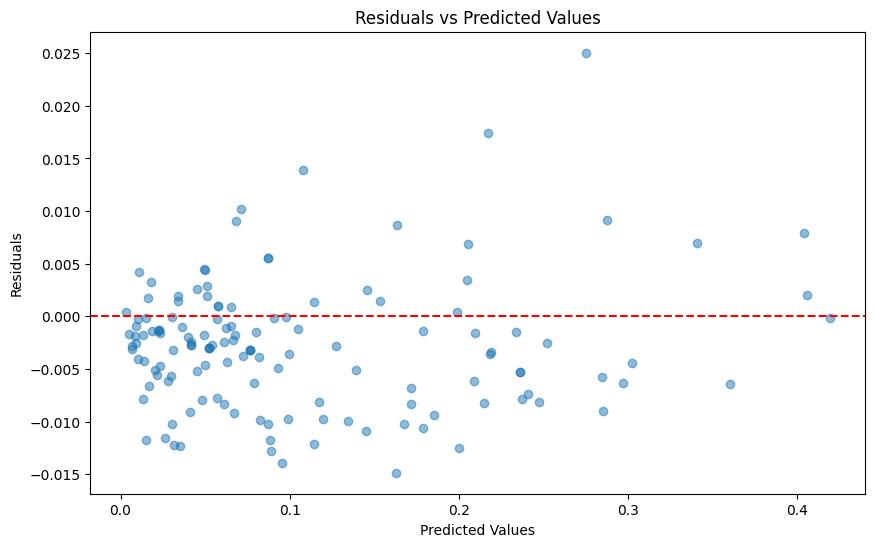

KeyboardInterrupt: 

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA PREPARATION + OUTLIER REMOVAL
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)', 'Final Raw Material cost (€/Part)'

]
cat_cols = [
    'Production', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'

# Remove outliers from target using IQR
Q1 = df[TARGET].quantile(0.25)
Q3 = df[TARGET].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df[TARGET] >= lower_bound) & (df[TARGET] <= upper_bound)]

X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# PREPROCESSING
# --------------------------
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)
], remainder='passthrough')

X_preprocessed = preprocessor.fit_transform(X)
cat_features_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))

# --------------------------
# HYPERPARAMETER SEARCH (RMSE focused)
# --------------------------
param_dist = {
    'iterations': [700, 850, 1000],
    'depth': [4, 6],
    'learning_rate': [0.02, 0.03, 0.05],
    'l2_leaf_reg': [1.0, 2.0, 3.0],
    'subsample': [0.65, 0.7, 0.75],
    'min_data_in_leaf': [30, 45, 60],
    'grow_policy': ['Depthwise']
}

base_model = CatBoostRegressor(
    cat_features=cat_features_indices,
    random_seed=42,
    verbose=False
)

search_result = base_model.randomized_search(
    param_dist,
    X_preprocessed,
    y,
    cv=3,
    refit=True,
    verbose=False,
    plot=False
)

best_params = search_result['params']
print("Best Hyperparameters Found:")
print(best_params)

# --------------------------
# 10-FOLD CROSS-VALIDATION
# --------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmses, maes, r2s = [], [], []

for train_idx, val_idx in kf.split(X_preprocessed):
    X_train, X_val = X_preprocessed[train_idx], X_preprocessed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_cv = CatBoostRegressor(
        **best_params,
        cat_features=cat_features_indices,
        random_seed=42,
        verbose=False
    )
    model_cv.fit(X_train, y_train)
    log_y_pred = model_cv.predict(X_val)
    y_pred = np.expm1(log_y_pred)
    y_val_original = np.expm1(y_val)
    
    rmses.append(mean_squared_error(y_val_original, y_pred, squared=False))
    maes.append(mean_absolute_error(y_val_original, y_pred))
    r2s.append(r2_score(y_val_original, y_pred))

print("\n10-Fold Cross-Validation Metrics:")
print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"MAE:  {np.mean(maes):.4f} ± {np.std(maes):.4f}")
print(f"R²:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")

# --------------------------
# FINAL MODEL & VISUALIZATION
# --------------------------
final_model = CatBoostRegressor(
    **best_params,
    cat_features=cat_features_indices,
    random_seed=42,
    verbose=False
)
final_model.fit(X_preprocessed, y)

log_y_pred_full = final_model.predict(X_preprocessed)
y_pred_full = np.expm1(log_y_pred_full)
residuals = y_original - y_pred_full

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_full, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    Pipeline([('model', final_model)]),
    X_preprocessed, y, cv=3,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(1), 'o-', label='Training')
plt.plot(train_sizes, -val_scores.mean(1), 'o-', label='Validation')
plt.title('Learning Curve (RMSE)')
plt.xlabel('Training Samples')
plt.ylabel('RMSE')
plt.legend()
plt.show()


# Log - Bon parametres enlevés + Faster research + Final Raw Material cost (€/Part)


bestTest = 0.06024366512
bestIteration = 685


bestTest = 0.06586007442
bestIteration = 698


bestTest = 0.06875433008
bestIteration = 482


bestTest = 0.064979789
bestIteration = 677


bestTest = 0.06640947355
bestIteration = 699


bestTest = 0.06277540427
bestIteration = 847


bestTest = 0.06144853328
bestIteration = 699


bestTest = 0.06228572647
bestIteration = 783


bestTest = 0.06391631915
bestIteration = 849


bestTest = 0.06705839732
bestIteration = 990

Training on fold [0/3]

bestTest = 0.06537036209
bestIteration = 699

Training on fold [1/3]

bestTest = 0.1298493802
bestIteration = 699

Training on fold [2/3]

bestTest = 0.08530446532
bestIteration = 699

Best Hyperparameters Found:
{'grow_policy': 'Depthwise', 'subsample': 0.7, 'min_data_in_leaf': 30, 'depth': 6, 'learning_rate': 0.02, 'l2_leaf_reg': 1, 'iterations': 700}


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mea


10-Fold Cross-Validation Metrics:
RMSE: 0.1258 ± 0.1328
MAE:  0.0665 ± 0.0622
R²:   0.9451 ± 0.0408


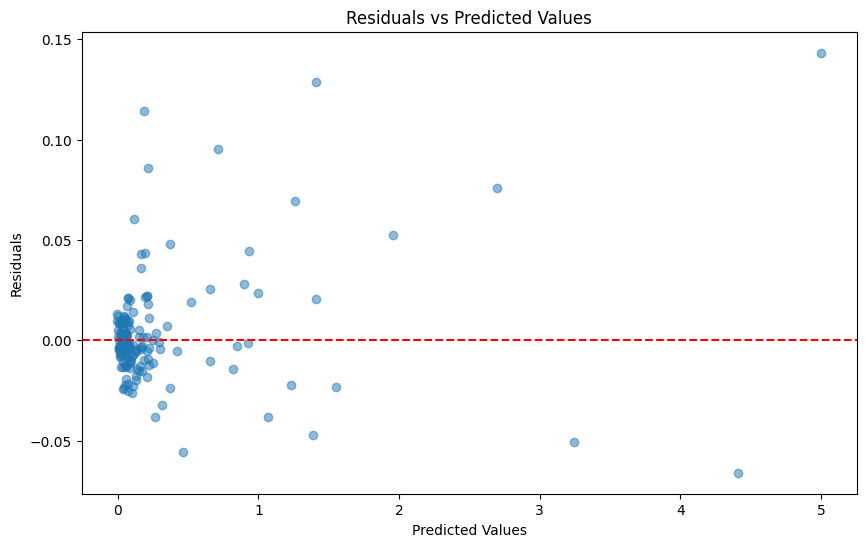

KeyboardInterrupt: 

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA PREPARATION + OUTLIER REMOVAL
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity',
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)'

]
cat_cols = [
    'Production', 
    'Raw Material Designation',
    'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'

X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# PREPROCESSING
# --------------------------
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)
], remainder='passthrough')

X_preprocessed = preprocessor.fit_transform(X)
cat_features_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))

# --------------------------
# HYPERPARAMETER SEARCH (RMSE focused)
# --------------------------
param_dist = {
    'iterations': [700, 850, 1000],
    'depth': [4, 6],
    'learning_rate': [0.02, 0.03, 0.05],
    'l2_leaf_reg': [1.0, 2.0, 3.0],
    'subsample': [0.65, 0.7, 0.75],
    'min_data_in_leaf': [30, 45, 60],
    'grow_policy': ['Depthwise']
}

base_model = CatBoostRegressor(
    cat_features=cat_features_indices,
    random_seed=42,
    verbose=False
)

search_result = base_model.randomized_search(
    param_dist,
    X_preprocessed,
    y,
    cv=3,
    refit=True,
    verbose=False,
    plot=False
)

best_params = search_result['params']
print("Best Hyperparameters Found:")
print(best_params)

# --------------------------
# 10-FOLD CROSS-VALIDATION
# --------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmses, maes, r2s = [], [], []

for train_idx, val_idx in kf.split(X_preprocessed):
    X_train, X_val = X_preprocessed[train_idx], X_preprocessed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_cv = CatBoostRegressor(
        **best_params,
        cat_features=cat_features_indices,
        random_seed=42,
        verbose=False
    )
    model_cv.fit(X_train, y_train)
    log_y_pred = model_cv.predict(X_val)
    y_pred = np.expm1(log_y_pred)
    y_val_original = np.expm1(y_val)
    
    rmses.append(mean_squared_error(y_val_original, y_pred, squared=False))
    maes.append(mean_absolute_error(y_val_original, y_pred))
    r2s.append(r2_score(y_val_original, y_pred))

print("\n10-Fold Cross-Validation Metrics:")
print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"MAE:  {np.mean(maes):.4f} ± {np.std(maes):.4f}")
print(f"R²:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")

# --------------------------
# FINAL MODEL & VISUALIZATION
# --------------------------
final_model = CatBoostRegressor(
    **best_params,
    cat_features=cat_features_indices,
    random_seed=42,
    verbose=False
)
final_model.fit(X_preprocessed, y)

log_y_pred_full = final_model.predict(X_preprocessed)
y_pred_full = np.expm1(log_y_pred_full)
residuals = y_original - y_pred_full

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_full, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    Pipeline([('model', final_model)]),
    X_preprocessed, y, cv=3,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(1), 'o-', label='Training')
plt.plot(train_sizes, -val_scores.mean(1), 'o-', label='Validation')
plt.title('Learning Curve (RMSE)')
plt.xlabel('Training Samples')
plt.ylabel('RMSE')
plt.legend()
plt.show()


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mea


10-Fold Cross-Validation Metrics:
RMSE: 0.1258 ± 0.1328
MAE:  0.0665 ± 0.0622
R²:   0.9451 ± 0.0408

Error Analysis:
Predictions within ±10%: 28.2%
Mean Absolute Percentage Error (MAPE): 49.95%


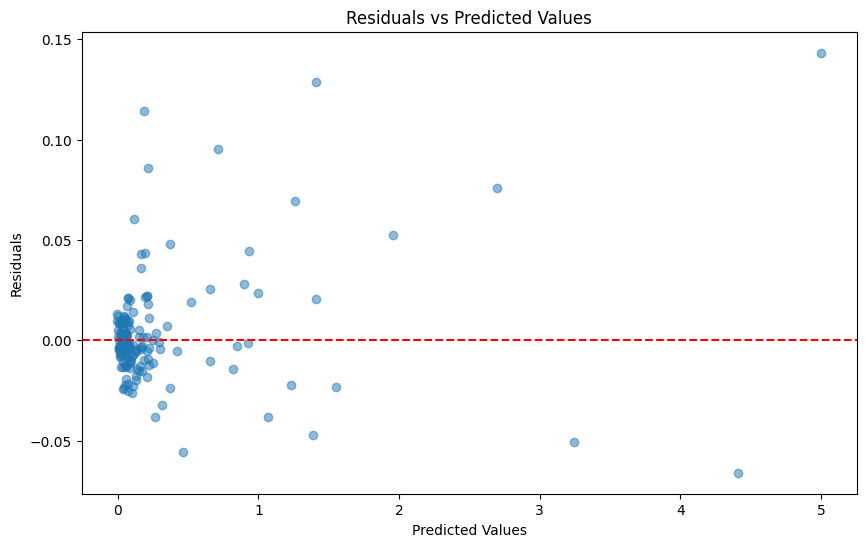

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA PREPARATION + OUTLIER REMOVAL
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)', 'Raw Material'
])

num_cols = [
    'Annual target quantity',
    'Raw Material Cost (€/kg)', 
    'Thickness (mm)',
    'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)',
    'Final Raw Material cost (€/Part)'
]
cat_cols = [
    'Production', 
    'Raw Material Designation',
    'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'

X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# PREPROCESSING
# --------------------------
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)
], remainder='passthrough')

X_preprocessed = preprocessor.fit_transform(X)
cat_features_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))

# --------------------------
# SET HYPERPARAMETERS
# --------------------------
best_params = {
    'grow_policy': 'Depthwise',
    'subsample': 0.7,
    'min_data_in_leaf': 30,
    'depth': 6,
    'learning_rate': 0.02,
    'l2_leaf_reg': 1,
    'iterations': 700
}

# --------------------------
# 10-FOLD CROSS-VALIDATION WITH ERROR ANALYSIS
# --------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmses, maes, r2s, percentages, ape = [], [], [], [], []

for train_idx, val_idx in kf.split(X_preprocessed):
    X_train, X_val = X_preprocessed[train_idx], X_preprocessed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_cv = CatBoostRegressor(
        **best_params,
        cat_features=cat_features_indices,
        random_seed=42,
        verbose=False
    )
    model_cv.fit(X_train, y_train)
    log_y_pred = model_cv.predict(X_val)
    y_pred = np.expm1(log_y_pred)
    y_val_original = np.expm1(y_val)
    
    # Calculate standard metrics
    rmses.append(mean_squared_error(y_val_original, y_pred, squared=False))
    maes.append(mean_absolute_error(y_val_original, y_pred))
    r2s.append(r2_score(y_val_original, y_pred))
    
    # Calculate percentage errors
    percentage_error = (y_val_original - y_pred) / y_val_original * 100
    within_10pct = (np.abs(percentage_error) <= 10).mean() * 100
    percentages.append(within_10pct)
    ape.append(np.mean(np.abs(percentage_error)))

print("\n10-Fold Cross-Validation Metrics:")
print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"MAE:  {np.mean(maes):.4f} ± {np.std(maes):.4f}")
print(f"R²:   {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
print(f"\nError Analysis:")
print(f"Predictions within ±10%: {np.mean(percentages):.1f}%")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(ape):.2f}%")

# --------------------------
# FINAL MODEL & VISUALIZATION
# --------------------------
final_model = CatBoostRegressor(
    **best_params,
    cat_features=cat_features_indices,
    random_seed=42,
    verbose=False
)
final_model.fit(X_preprocessed, y)

log_y_pred_full = final_model.predict(X_preprocessed)
y_pred_full = np.expm1(log_y_pred_full)
residuals = y_original - y_pred_full

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_full, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()